# Evaluation

We'll perform evaluation for a model trained on SDSS data to illustrate.

### Semi-Synthetic Data: SDSS

Let's look at some images generated in this manner. We plot 10 example images, each in the $u,g,r,i,z$ bands. By default, BLISS chooses the SDSS survey with reference band $r$, and we make no modifications to this.

In [1]:
import torch
import numpy as np
import math
import os
import torch
import pytorch_lightning as pl
from hydra.utils import instantiate
import matplotlib.pyplot as plt
from case_studies.redshift_estimation.catalog import RedshiftFullCatalog, RedshiftTileCatalog
from bliss.encoder.plotting import plot_detections, my_plot_detections

In [2]:
from os import environ
environ["CUDA_VISIBLE_DEVICES"] = "4"

from pathlib import Path
from hydra import initialize, compose
from bliss.main import predict

environ["BLISS_HOME"] = str("/home/declan/current/bliss")

In [3]:
with initialize(config_path="../..", version_base=None):
    cfg = compose("redshift", {})

In [4]:
# This cell will take some time to run to load the dataset
pl.seed_everything(cfg.train.seed)

# setup dataset and encoder
dataset = instantiate(cfg.train.data_source)
encoder = instantiate(cfg.train.encoder)

Global seed set to 42


In [7]:
train_dataloader = dataset.train_dataloader() 
batch = next(iter(train_dataloader))
print('Batch of images is of shape {}'.format(batch['images'].shape))

Batch of images is of shape torch.Size([32, 5, 80, 80])


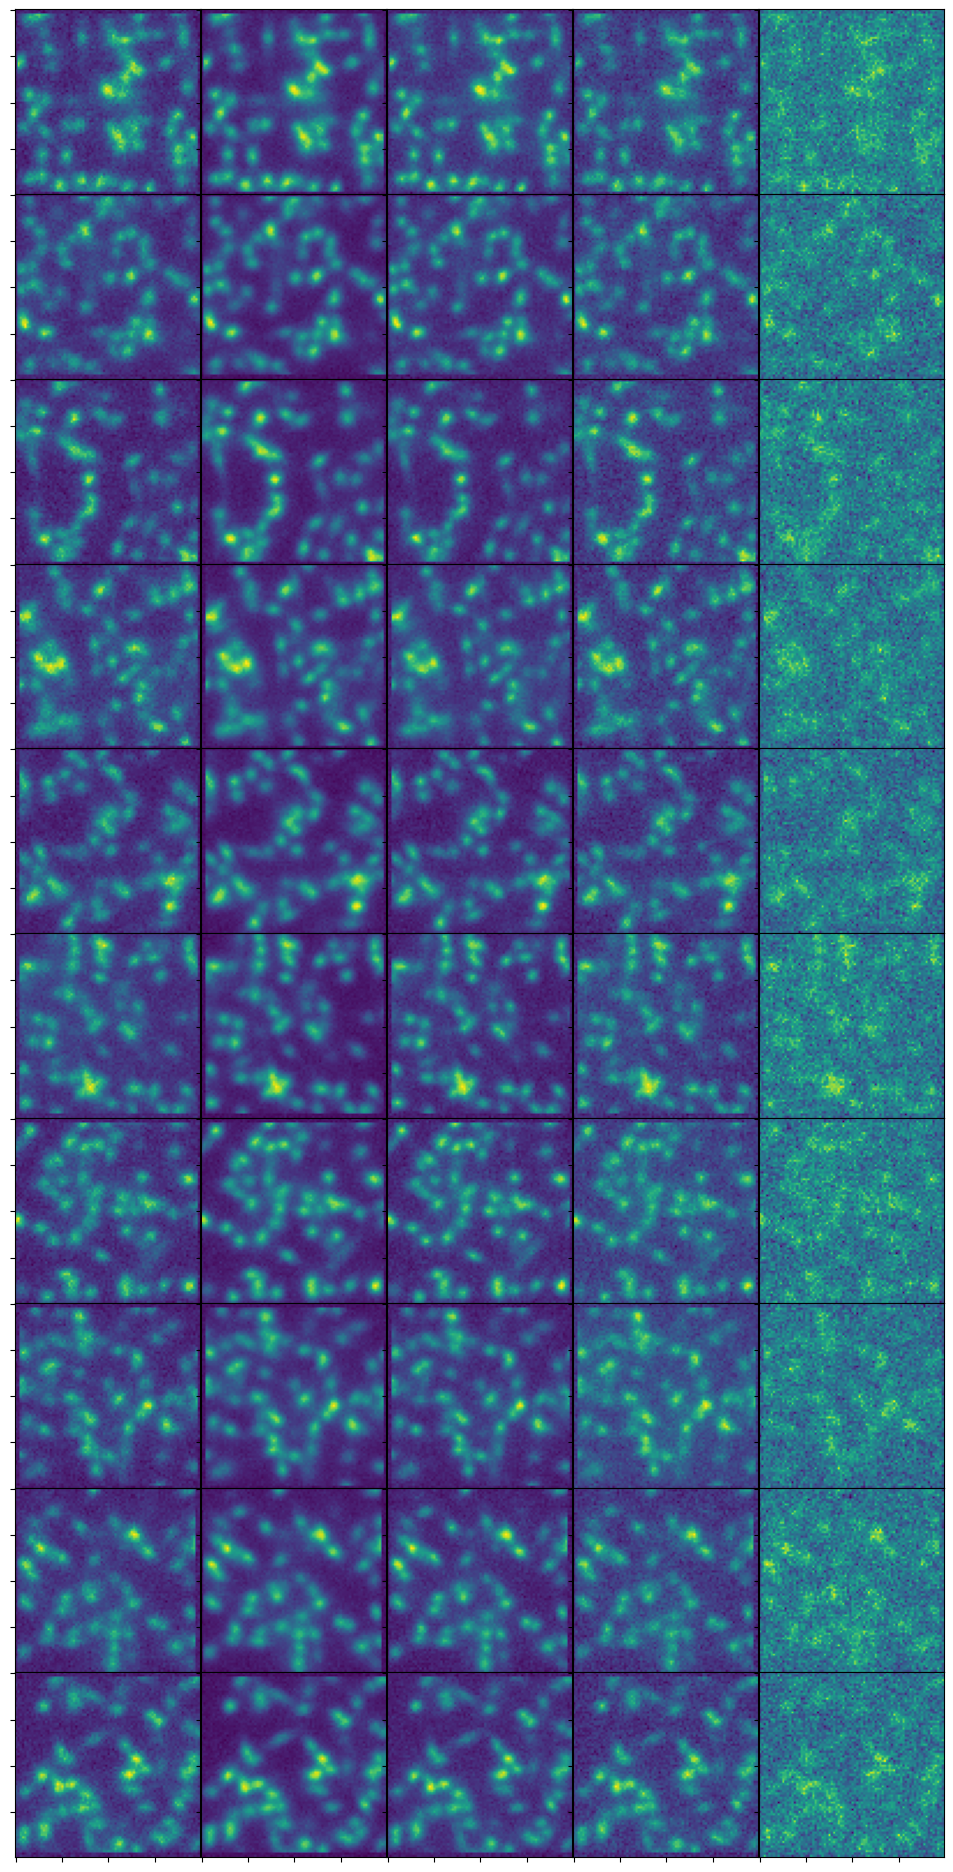

In [8]:
n_to_show = 10
_, axs = plt.subplots(10, 5, figsize=(12,24))
axs = axs.flatten()
imgs = batch['images'][:10].flatten(start_dim=0,end_dim=1)
for img, ax in zip(imgs, axs):
    ax.imshow(img)
    
for a in axs:
    a.set_xticklabels([])
    a.set_yticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### In-Sample Training Results: SDSS

We fit the encoder using the BLISS pipeline. Essentially, photo-$z$ estimation is performed via a module in parallel to the existing pipeline: the current pipeline estimates locations, types, and fluxes of each astronomical object. We simply add outputs to the encoder network that are used to parameterize the variational distributions on redshift.

Currently, the variational distributions on redshift are univariate Gaussian; a mixture of Gaussians could be used in the future. As with other quantities, the per-tile NLL contribution for redshift is conditioned on the presence of a true source in that tile, etc. We leave other aspects of BLISS unchanged, so in addition we also estimate the number of sources, the type of each source, the fluxes and galaxy parameters of each source, etc.

Let's load the fitted encoder and check that we are detecting sources properly. We overlay red "x"s on the posterior mode per-tile of the detected source, if a source is detected in that tile. We'll just overlay on top of the r-band image, as we don't have coaddition support for SDSS.

In [10]:
PATH = "/home/declan/current/bliss/redshift_output/version_2/checkpoints/best_encoder.ckpt"
checkpoint = torch.load(PATH)
encoder.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [11]:
est_cat = encoder.sample(batch, use_mode=True) # I'm using the mode to predict
est_cat = est_cat.to_dict()

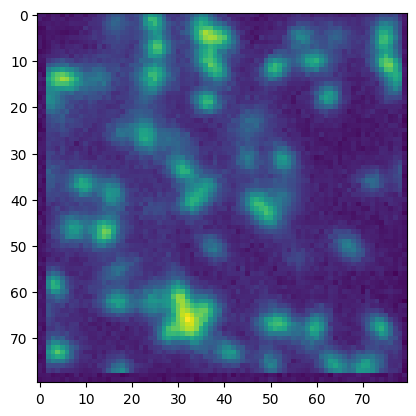

In [12]:
# Plot r_band for a selected image, overlay detected source locations
image_to_show = 5
fig, ax = plt.subplots()
ax.imshow(batch['images'][image_to_show].sum(0)) # Coadd by simple summation

In [13]:
target_cat = RedshiftTileCatalog(encoder.tile_slen, batch["tile_catalog"])
target_cat = target_cat.filter_tile_catalog_by_flux(min_flux=encoder.min_flux_threshold)
target_cat_cropped = target_cat.symmetric_crop(encoder.tiles_to_crop)
est_cat = encoder.sample(batch, use_mode=True)

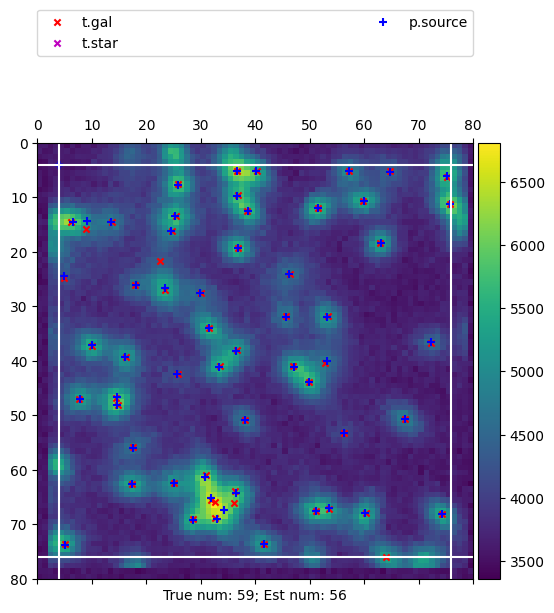

In [14]:
mp = encoder.tiles_to_crop * encoder.tile_slen
fig = my_plot_detections(image_to_show, batch["images"], target_cat_cropped, est_cat, margin_px=mp, figsize=(6,6))

Evidently, we're not doing terribly at predicting sources or their locations; let's assume then that we havne't broken the existing functionality of BLISS. We're interested in the quality of our photometric redshift estimates though. Let's plot these in a scatterplot across the whole training set. This will be quite a dense scatterplot because of the sheer number of images we train on.

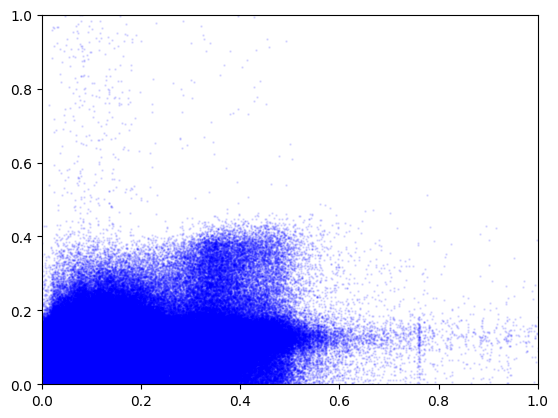

In [15]:
fig, ax = plt.subplots()


for idx, batch in enumerate(train_dataloader):
    est_cat = encoder.sample(batch, use_mode=True)
    pred_redshifts = est_cat.to_dict()['redshifts']
    true_redshifts = batch['tile_catalog']['redshifts']
    
    # Cut out border of true_redshifts
    true_redshifts = true_redshifts[:,1:-1,1:-1]
    true_redshifts = true_redshifts.squeeze(-1)
    
    # Add this batch to scatterplot
    ax.scatter(true_redshifts.detach().numpy(), pred_redshifts.detach().numpy(), c='b', marker='.', s=3, alpha=0.1)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
    # Too many objects so we break early here
    if idx > 100:
        break

This isn't a great result; we'd rather than scattplot look as close to the line $y=x$ as possible.